In [17]:
import pandas as pd
import time
import numpy as np

# Load the raw IMU CSV data
file_path = "data/imu.csv"
with open(file_path, "r") as f:
    lines = f.readlines()

# Define the parsing function

def get_pitch_roll_from_gravity(gx, gy, gz):
    pitch = np.degrees(np.arcsin(-gx / np.linalg.norm([gx, gy, gz])))
    roll = np.degrees(np.arctan2(gy, gz))

    roll = ((roll + 90) % 180) - 90

    return pitch, roll

def quaternion_to_euler(q):
    """
    Convert a quaternion into Euler angles (roll, pitch, yaw).

    Args:
        q (list): Quaternion [x, y, z, w]

    Returns:
        tuple: (roll, pitch, yaw) in degrees
    """
    w, y, x, z = q
    z = -z 
    sqw = w * w
    sqx = x * x
    sqy = y * y
    sqz = z * z

    yaw = np.arctan2(2.0 * (x * y + z * w), (sqx - sqy - sqz + sqw))
    pitch = np.arcsin(-2.0 * (x * z - y * w) / (sqx + sqy + sqz + sqw))
    roll = np.arctan2(2.0 * (y * z + x * w), (-sqx - sqy + sqz + sqw))

    return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)

def parse_line(line):
    parts = line.strip().split(",")
    data = {}

    for part in parts:
        try:
            key, *values = part.split(":")
            if key in ["q", "gq", "a", "la", "g", "m", "grav"]:
                data[key] = [float(v) for v in values]
            elif key == "steps":
                data[key] = int(values[0])
            elif key == "stab":
                data[key] = values[0]
        except Exception as e:
            print(f"[IMU_BNO085] Parse error for {part}: {e}")

    if "q" in data:
        data["euler"] = quaternion_to_euler(data["q"])
    data["unix_time"] = time.time()

    return data

# Apply the function to each line
parsed_data = [parse_line(line) for line in lines]

# Convert to a DataFrame
df = pd.DataFrame(parsed_data)

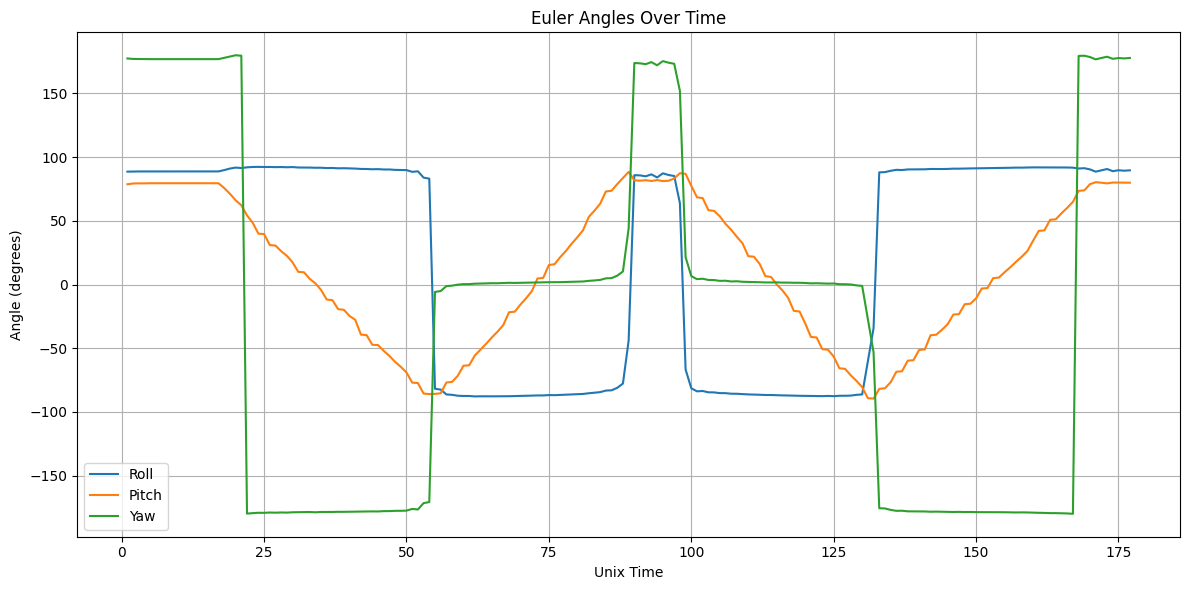

In [7]:
import matplotlib.pyplot as plt

# Extract Euler angles from the DataFrame
df_valid = df[df["euler"].notnull()].copy()
df_valid[["roll", "pitch", "yaw"]] = pd.DataFrame(df_valid["euler"].tolist(), index=df_valid.index)

# Plot pitch, yaw, and roll
plt.figure(figsize=(12, 6))
plt.plot(df_valid["roll"], label="Roll")
plt.plot(df_valid["pitch"], label="Pitch")
plt.plot(df_valid["yaw"], label="Yaw")
plt.xlabel("Unix Time")
plt.ylabel("Angle (degrees)")
plt.title("Euler Angles Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

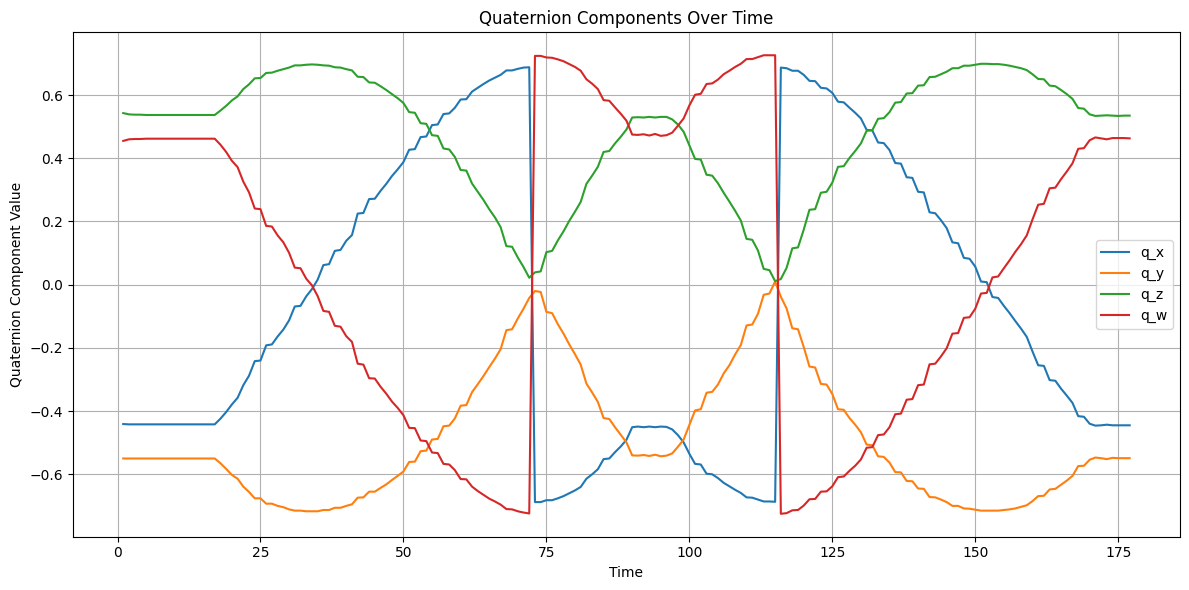

In [8]:
df_valid[["q_w", "q_y", "q_x", "q_z"]] = pd.DataFrame(df_valid["q"].tolist(), index=df_valid.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_valid["q_x"], label="q_x")
plt.plot(df_valid["q_y"], label="q_y")
plt.plot(df_valid["q_z"], label="q_z")
plt.plot(df_valid["q_w"], label="q_w")
plt.xlabel("Time")
plt.ylabel("Quaternion Component Value")
plt.title("Quaternion Components Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

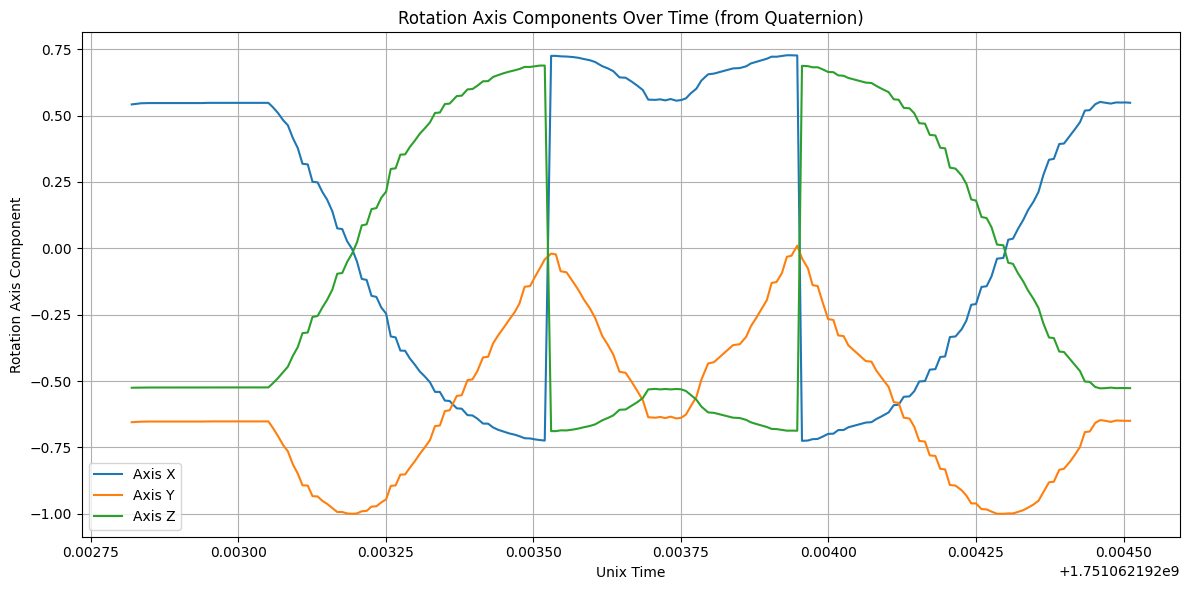

In [9]:
# Assume df_valid is already defined and contains a 'q' column with valid quaternions

# Function to extract rotation axis from quaternion
def get_rotation_axis(q):
    x, y, z, w = q
    angle = 2 * np.arccos(w)
    sin_half_angle = np.sqrt(1 - w**2)
    if sin_half_angle < 1e-6:
        return (0.0, 0.0, 0.0)  # angle is 0, axis undefined
    return (x / sin_half_angle, y / sin_half_angle, z / sin_half_angle)

# Apply function
df_valid["rot_axis"] = df_valid["q"].apply(get_rotation_axis)
df_valid[["axis_x", "axis_y", "axis_z"]] = pd.DataFrame(df_valid["rot_axis"].tolist(), index=df_valid.index)

# Plot rotation axis components over time
plt.figure(figsize=(12, 6))
plt.plot(df_valid["unix_time"], df_valid["axis_x"], label="Axis X")
plt.plot(df_valid["unix_time"], df_valid["axis_y"], label="Axis Y")
plt.plot(df_valid["unix_time"], df_valid["axis_z"], label="Axis Z")
plt.xlabel("Unix Time")
plt.ylabel("Rotation Axis Component")
plt.title("Rotation Axis Components Over Time (from Quaternion)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
file_path = "data/imu_new.csv"
with open(file_path, "r") as f:
    lines = f.readlines()
parsed_data = [parse_line(line) for line in lines]

# Convert to a DataFrame
df_new = pd.DataFrame(parsed_data)

In [11]:
times = [float(line.strip().split(',')[0]) for line in lines[1:]]
print(times)

[733.42, 734.06, 734.7, 735.34, 735.96, 736.61, 737.36, 737.99, 738.67, 739.31, 739.96, 740.71, 741.35, 741.99, 742.62, 743.26, 744.0, 744.63, 745.27, 745.91, 746.55, 747.3, 747.94, 748.57, 749.21, 749.85, 750.6, 751.24, 751.87, 752.56, 753.2, 753.94, 754.58, 755.21, 755.85, 756.48, 757.22, 757.86, 758.5, 759.13, 759.76, 760.5, 761.14, 761.77, 762.4, 763.04, 763.79, 764.42, 765.05, 765.73, 766.37, 766.99, 767.74, 768.38, 769.02, 769.65, 770.29, 771.03, 771.66, 772.29, 772.92, 773.56, 774.29, 774.93, 775.57, 776.2, 776.83, 777.58, 778.23, 778.91, 779.54, 780.17, 780.91, 781.54, 782.17, 782.81, 783.44, 784.17, 784.8, 785.44, 786.07, 786.71, 787.44, 788.07, 788.71, 789.35, 789.98, 790.72, 791.36, 792.0, 792.68, 793.32, 793.96, 794.69, 795.32, 795.96, 796.6, 797.24, 797.97, 798.61, 799.25, 799.89, 800.52, 801.26, 801.9, 802.54, 803.17, 803.8, 804.54, 805.17, 805.8, 806.49, 807.13, 807.86, 808.5, 809.14, 809.77, 810.4, 811.14, 811.77, 812.41, 813.05, 813.69, 814.43, 815.06, 815.7, 816.34, 8

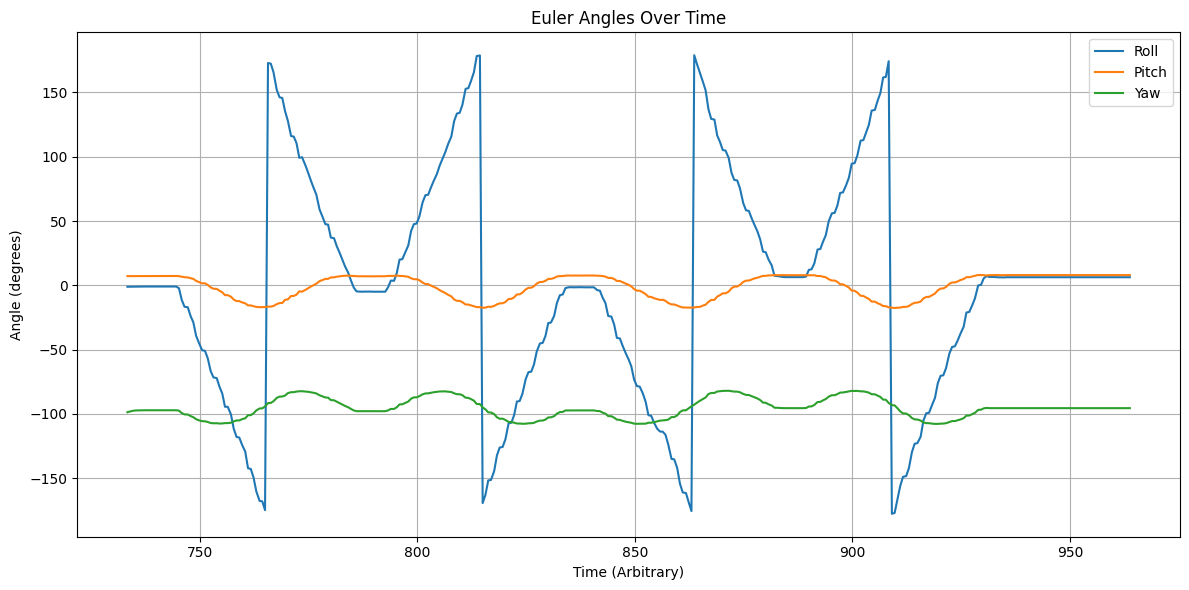

In [19]:
# Extract Euler angles from the DataFrame
df_newvalid = df_new[df_new["euler"].notnull()].copy()
df_newvalid[["roll", "pitch", "yaw"]] = pd.DataFrame(df_newvalid["euler"].tolist(), index=df_newvalid.index)

# Plot pitch, yaw, and roll
plt.figure(figsize=(12, 6))
plt.plot(times,df_newvalid["roll"], label="Roll")
plt.plot(times,df_newvalid["pitch"], label="Pitch")
plt.plot(times,df_newvalid["yaw"], label="Yaw")
plt.xlabel("Time (Arbitrary)")
plt.ylabel("Angle (degrees)")
plt.title("Euler Angles Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

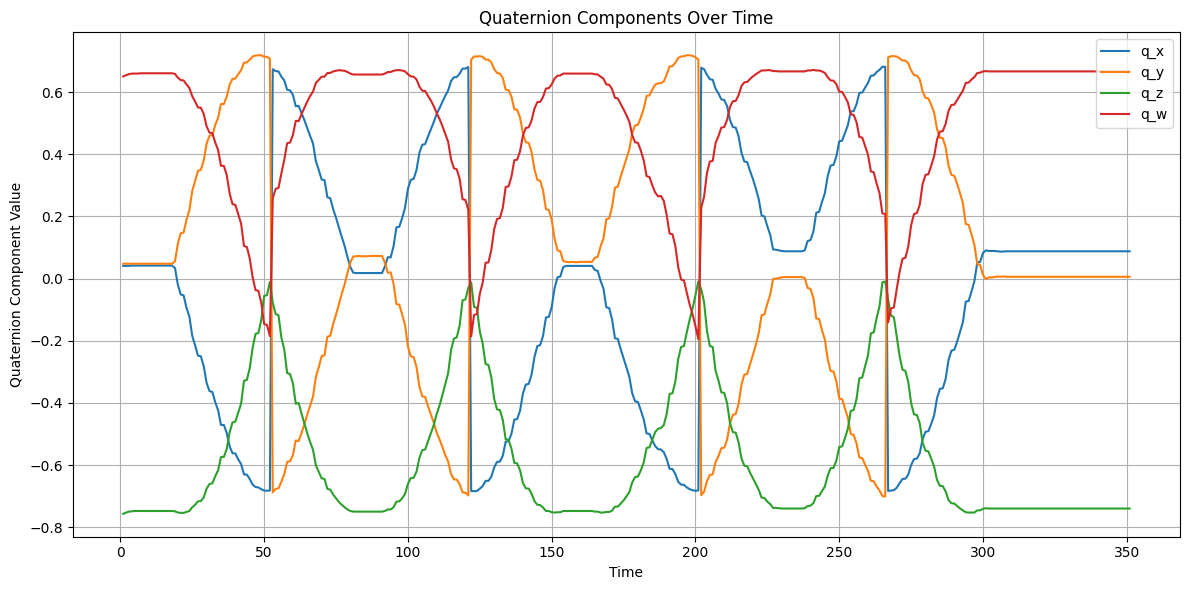

In [16]:
df_newvalid[["q_w", "q_y", "q_x", "q_z"]] = pd.DataFrame(df_newvalid["q"].tolist(), index=df_newvalid.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_newvalid["q_x"], label="q_x")
plt.plot(df_newvalid["q_y"], label="q_y")
plt.plot(-df_newvalid["q_z"], label="q_z")
plt.plot(df_newvalid["q_w"], label="q_w")
plt.xlabel("Time")
plt.ylabel("Quaternion Component Value")
plt.title("Quaternion Components Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [177]:
file_path = "data/serial_log.csv"
with open(file_path, "r") as f:
    lines = f.readlines()

In [204]:
pos_els = [int(line.strip().split(',')[2]) for line in lines[1:]]
times_motor = [int(line.strip().split(',')[0]) for line in lines[1:]]

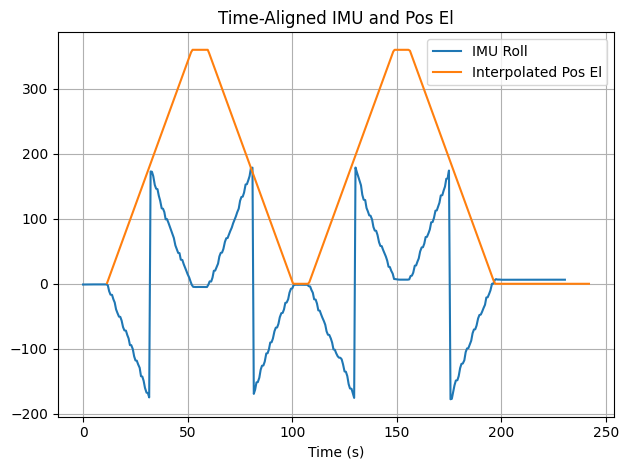

-81.9364613827759
-107.76169614007313


In [247]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Example truncated: Replace with full lists in actual use
imu_times = times
posel_unix_times = times_motor

# Convert posel_unix_times to relative time (starting at 0, in seconds)
posel_times = (np.array(posel_unix_times) - posel_unix_times[0]) / 1e6

# Normalize imu_times to start at 0
imu_times_aligned = np.array(imu_times) - imu_times[0]

# Interpolate pos_el onto the imu_times axis
# For now we fake pos_el values to illustrate the interpolation
posel_interp = np.interp(imu_times_aligned, posel_times, pos_els)
posel_scaled = 360 * (posel_interp - posel_interp.min()) / (posel_interp.max() - posel_interp.min())
# Plot
plt.plot(imu_times_aligned, df_valid["roll"], label="IMU Roll")
plt.plot(imu_times_aligned+11.5, posel_scaled, label="Interpolated Pos El")
plt.xlabel("Time (s)")
plt.legend()
plt.title("Time-Aligned IMU and Pos El")
plt.grid(True)
plt.tight_layout()
plt.show()

print(np.max(df_valid["yaw"]))
print(np.min(df_valid["yaw"]))

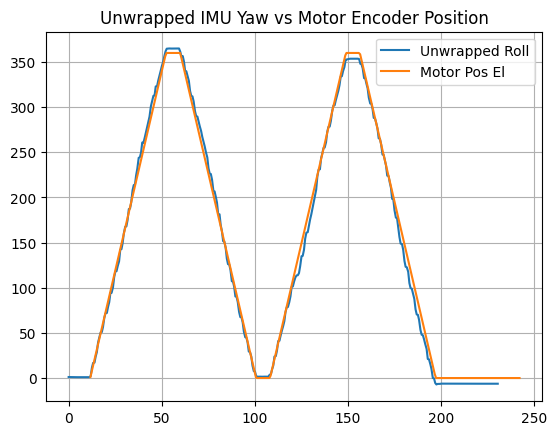

7.132158116769244


In [246]:
roll_radians = np.radians(df_valid["roll"])
roll_unwrapped = np.unwrap(roll_radians)
roll_unwrapped_degrees = np.degrees(roll_unwrapped)

posel_scaled = 360 * (posel_interp - posel_interp.min()) / (posel_interp.max() - posel_interp.min())

plt.plot(imu_times_aligned, yaw_unwrapped_degrees, label="Unwrapped Roll")
plt.plot(imu_times_aligned+11.7, posel_scaled, label="Motor Pos El")
plt.legend()
plt.title("Unwrapped IMU Yaw vs Motor Encoder Position")
plt.grid(True)
plt.show()

print(np.max(-yaw_unwrapped_degrees))